# Recalage d'images par maximisation de l'information mutuelle

In [17]:
!pip install --upgrade pip
!pip install SimpleITK
!pip install ipywidgets
import SimpleITK as sitk

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import math

On définit ici quelque fonction utiles.

In [18]:
def MultiImageDisplay2D(imageList, titleList=None, windowLevelList= None, figureSize=(10,8), horizontal=True):

    if titleList:
        if len(imageList)!=len(titleList):
            raise ValueError('Title list and image list lengths do not match')
    else:
        titleList = ['']*len(imageList)

    # Create a figure.
    col_num, row_num = (len(imageList), 1)  if horizontal else (1, len(imageList))
    fig, axes = plt.subplots(row_num, col_num, figsize=figureSize)
    if len(imageList)==1:
        axes = [axes]

    # Get images as numpy arrays for display and the window level settings
    npa_list = list(map(sitk.GetArrayViewFromImage, imageList))
    if not windowLevelList:
        min_intensity_list = list(map(np.min, npa_list))
        max_intensity_list = list(map(np.max, npa_list))
    else:
        min_intensity_list = list(map(lambda x: x[1]-x[0]/2.0, windowLevelList))
        max_intensity_list = list(map(lambda x: x[1]+x[0]/2.0, windowLevelList))

    # Draw the image(s)
    for ax, npa, title, min_intensity, max_intensity in zip(axes, npa_list, titleList, min_intensity_list, max_intensity_list):
        ax.imshow(npa,
                  cmap=plt.cm.Greys_r,
                  vmin=min_intensity,
                  vmax=max_intensity)
        ax.set_title(title)
        ax.set_axis_off()
    fig.tight_layout()
    
    return (fig, axes)


def LoadControlPoints(fileName) :
    file = open(fileName,'r')
    points = []
    
    for line in file.readlines() :
        aLFloat = [] 
        for x in  line.split(" ") :
            aLFloat.append(float(x))
        
        x1,y1,x2,y2 = aLFloat[0:4]
        points.append([[x1,y1],[x2,y2]])
        
    file.close()
    return points

def EuclidianDistance(p, q) :
    return math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(p, q)))

On charge les images à recaler.

In [19]:
fixedImage =  sitk.ReadImage('dataset/images/kidney_5_1.jpg', sitk.sitkFloat32)
movingImage = sitk.ReadImage('dataset/images/kidney_5_2.jpg', sitk.sitkFloat32)

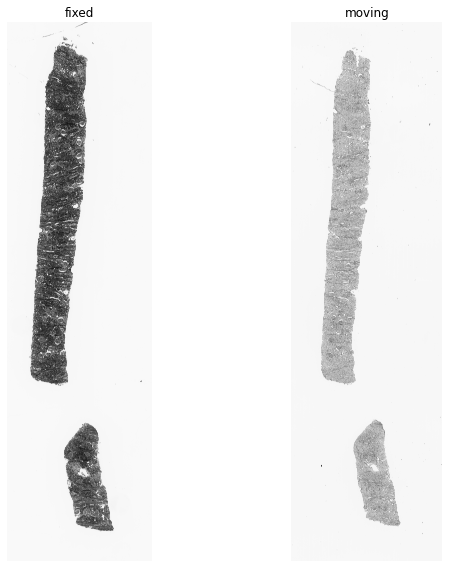

In [20]:
MultiImageDisplay2D(imageList = [fixedImage, movingImage],                   
                      titleList = ['fixed', 'moving']);

On définit le type de transformation qu'on cherche et on initialise l'algorithme en alignant les centres des images.

In [21]:
initialTransform = sitk.CenteredTransformInitializer(fixedImage, movingImage, sitk.AffineTransform(fixedImage.GetDimension()))

In [22]:
registration = sitk.ImageRegistrationMethod()

registration.SetShrinkFactorsPerLevel([3, 2, 1])
registration.SetSmoothingSigmasPerLevel([2, 1, 1])

#Use mutual information
registration.SetMetricAsJointHistogramMutualInformation()

#use GD as optimizer
registration.MetricUseFixedImageGradientFilterOff()
registration.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100,
                                           estimateLearningRate=registration.EachIteration)

registration.SetOptimizerScalesFromPhysicalShift()

registration.SetInitialTransform(initialTransform)
registration.SetInterpolator(sitk.sitkLinear)

transform = registration.Execute(fixedImage, movingImage)
inverseTransform = transform.GetInverse()

print("Transform : \n", transform)
print("Optimizer stop condition: {0}".format(registration.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(registration.GetOptimizerIteration()))
print(" Metric value: {0}".format(registration.GetMetricValue()))


Transform : 
 itk::simple::Transform
 AffineTransform (00000278A6324B00)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 102431
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.03822 0.00365936 
     -0.0185713 1.0049 
   Offset: [37.7106, 129.464]
   Center: [1844.88, 6750.07]
   Translation: [132.925, 128.309]
   Inverse: 
     0.963123 -0.00350722 
     0.0177992 0.995054 
   Singular: 0

Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
 Iteration: 9
 Metric value: -1.528406374876925


Visualisation des résultats.

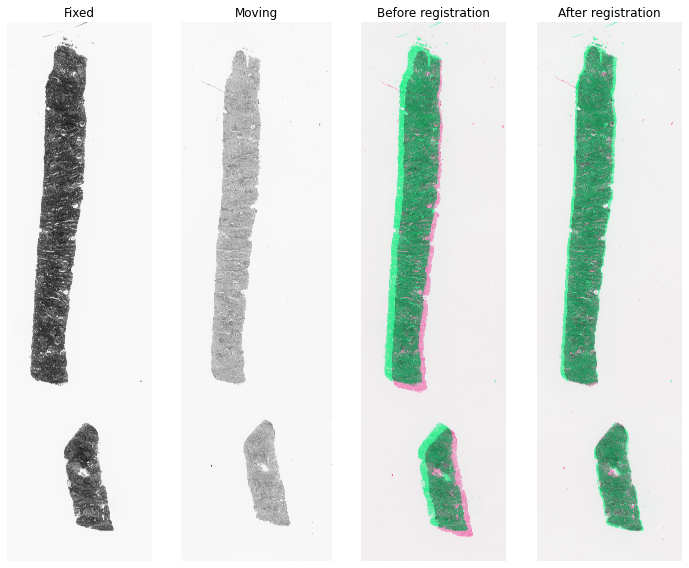

In [23]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixedImage)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)

originalImage = resampler.Execute(movingImage)

resampler.SetTransform(transform)
transformedImage = resampler.Execute(movingImage)
  
castedImg1 = sitk.Cast(sitk.RescaleIntensity(fixedImage), sitk.sitkUInt8)
castedImg2 = sitk.Cast(sitk.RescaleIntensity(originalImage), sitk.sitkUInt8)
castedImg3 = sitk.Cast(sitk.RescaleIntensity(transformedImage), sitk.sitkUInt8)

composedImg1 = sitk.Compose(castedImg1, castedImg2, castedImg1 // 2. + castedImg2 // 2.)
composedImg2 = sitk.Compose(castedImg1, castedImg3, castedImg1 // 2. + castedImg3 // 2.)

MultiImageDisplay2D(imageList = [fixedImage, movingImage, composedImg1, composedImg2],                   
                      titleList = ['Fixed', 'Moving', 'Before registration', 'After registration']);

Charge les points de contrôle pour calculer la TRE.

In [24]:
controlPoints = LoadControlPoints('dataset/control points/control_points_kidney_5.txt')

Calcul de la TRE.

In [25]:
TRE = []

meanTREBe = 0
meanTREAf = 0


for pt1, pt2 in controlPoints: 
    TRE.append(EuclidianDistance(pt1, inverseTransform.TransformPoint(pt2)))
    
    meanTREBe+= EuclidianDistance(pt1, pt2)
    meanTREAf+= EuclidianDistance(pt1, inverseTransform.TransformPoint(pt2))
    
meanTREBe /= len(controlPoints)
meanTREAf /= len(controlPoints)

print("Mean distance before registration : \n", meanTREBe)
print("Mean TRE : \n", meanTREAf)

Mean distance before registration : 
 187.5730149419016
Mean TRE : 
 48.05411773792155


Affiche la distribution de la TRE.

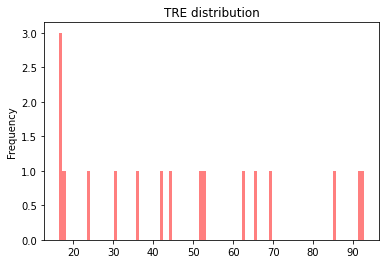

In [26]:
plt.hist(TRE, color='r', bins=100, alpha=0.5)
plt.gca().set(title='TRE distribution', ylabel='Frequency');